In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from hhdc.canopy_plots import create_chm

cubes = []
for subfolder in os.listdir("cubes/SERC"):
    subfolder_path = os.path.join("cubes/SERC", subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.endswith('.npz'):
                cubes.append(os.path.join(subfolder_path, file))

print(f"Found {len(cubes)} cubes.")

Found 46043 cubes.


# 16 Random CHMs

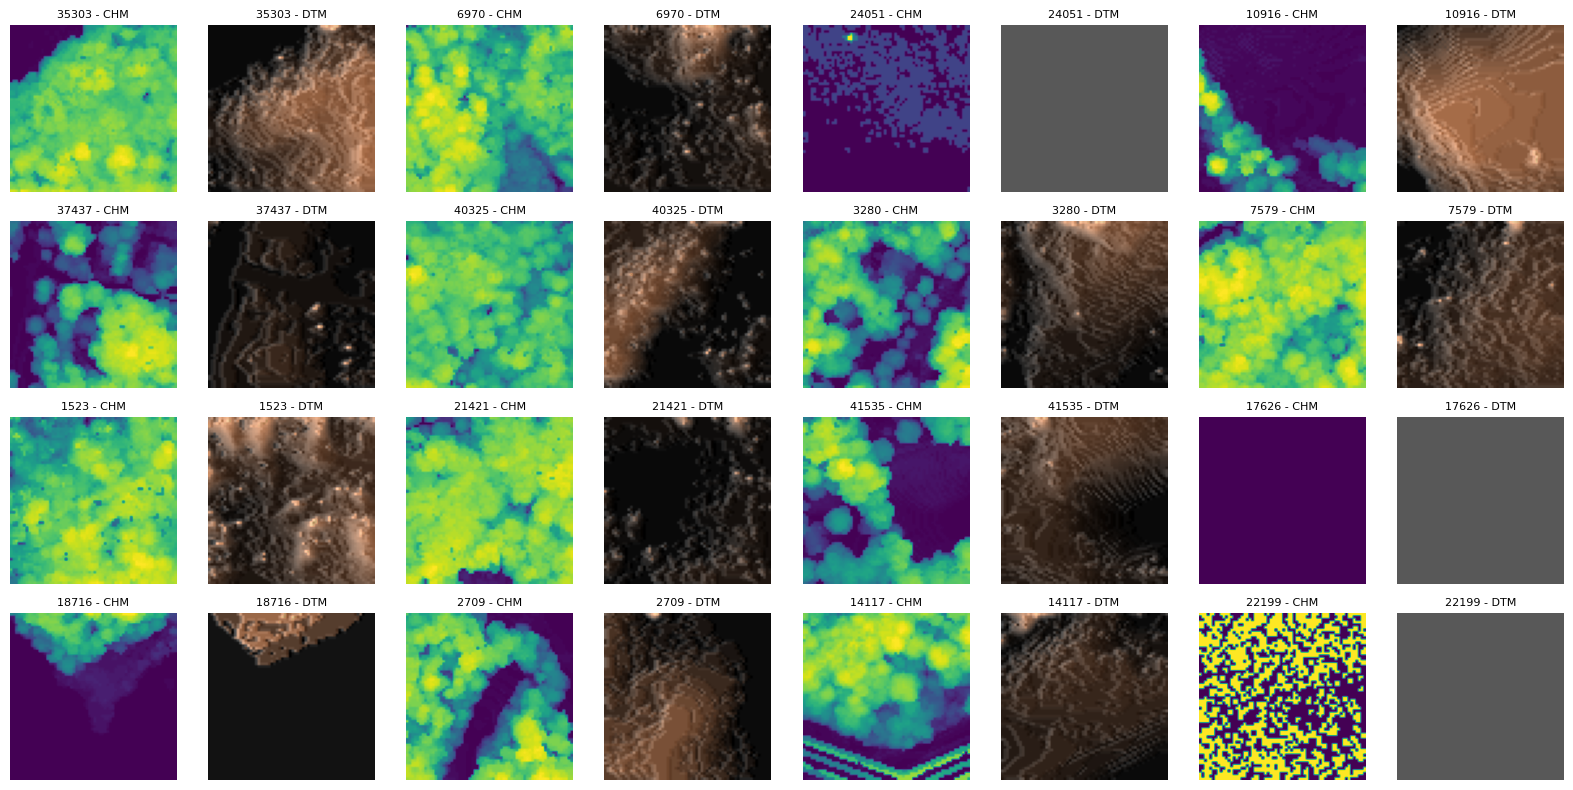

In [5]:
import random

num_samples = 16
random_indices = random.sample(range(len(cubes)), num_samples)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for sample_idx, cube_idx in enumerate(random_indices):
    cube_path = cubes[cube_idx]
    cube_data = np.load(cube_path)['cube']
    chm, dtm, hillshade, _ = create_chm(np.swapaxes(cube_data, 0, -1))

    chm_ax = axes[sample_idx * 2]
    dtm_ax = axes[sample_idx * 2 + 1]

    chm_ax.imshow(chm)
    chm_ax.set_title(f"{cube_idx} - CHM", fontsize=8)
    chm_ax.axis('off')

    dtm_ax.imshow(dtm, cmap='copper')
    dtm_ax.imshow(hillshade, cmap='Greys', alpha=0.35)
    dtm_ax.set_title(f"{cube_idx} - DTM", fontsize=8)
    dtm_ax.axis('off')

plt.tight_layout()
plt.show()
